# Subspace v.s. PULSE

In [35]:
import jax
import keras
import einops
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [6]:
from rebayes_mini import callbacks
from rebayes_mini.methods import subspace_filter

In [7]:
%config InlineBackend.figure_format = "retina"

In [ ]:
key = jax.random.PRNGKey(314)

In [41]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train / jnp.max(X_train)
X_test = X_test / jnp.max(X_test)

X_train = einops.rearrange(X_train, "samples width height -> samples (width height)")
X_test = einops.rearrange(X_test, "samples width height -> samples (width height)")

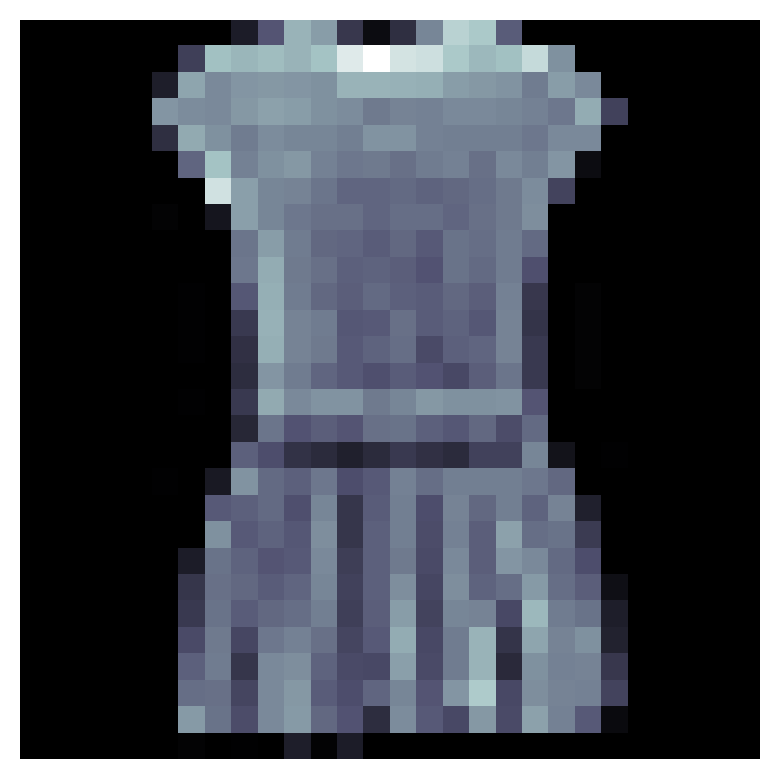

In [44]:
plt.imshow(X_train[3].reshape(28, 28), cmap="bone")
plt.axis("off");

In [54]:
@subspace_filter.subcify
class NNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

In [55]:
dim_in = 28 ** 2
dim_subspace = 20
model = NNet(dim_in, dim_subspace)

In [56]:
X_train.shape

(60000, 784)

In [57]:
params_init = model.init(key, X_train[0])
jax.tree_map(jnp.shape, params_init)

{'fixed': {'P': (89610, 20), 'b': (89610,)}, 'params': {'subspace': (20,)}}

In [60]:
p_fixed = params_init["fixed"]

def applyfn(p_subspace, X):
    pfull = {
        "fixed": p_fixed,
        "params": p_subspace
    }
    return model.apply(pfull, X)


In [61]:
applyfn(params_init["params"], X_train[0])

Array([ 0.00230099, -0.00598955,  0.00264122, -0.00349194,  0.00866351,
        0.01741693, -0.01650017,  0.00850966, -0.01609809, -0.00547172],      dtype=float32)

In [58]:
model.apply(params_init, X_train[0])

Array([ 0.00230099, -0.00598955,  0.00264122, -0.00349194,  0.00866351,
        0.01741693, -0.01650017,  0.00850966, -0.01609809, -0.00547172],      dtype=float32)